### Long Short-Term Memory (LSTM) RNN Model for Sales Forecasting

In [ ]:
# Import dependencies
import os

In [257]:
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:
# Skip this step after first install (for reruns)
!pip install git+https://github.com/statsmodels/statsmodels

In [280]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

#### Import data from csv, review and cleanup 

In [261]:
pd.set_option('max_colwidth', 200)
walmart_df = pd.read_csv("walmart_cleaned.csv")

In [ ]:
walmart_df.head(2)

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [262]:
# Change Date column from string to datetime, include year column, month column, week column and year_week columns to use for groupby later 
walmart_df['Date'] = pd.to_datetime(walmart_df['Date'])
walmart_df['week_of_year'] = walmart_df['Date'].dt.isocalendar().week
walmart_df['year'] = walmart_df['Date'].dt.year
walmart_df['year_week'] = walmart_df['year'] * 100 + walmart_df['week_of_year']
walmart_df['year_week'] = walmart_df['year_week'].astype(int)
walmart_df.dtypes

Unnamed: 0               int64
Store                    int64
Date            datetime64[ns]
IsHoliday                int64
Dept                   float64
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                     int64
Size                     int64
week_of_year            UInt32
year                     int64
year_week                int64
dtype: object

In [263]:
walmart_df.head(2)

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week_of_year,year,year_week
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,5,2010,201005
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315,5,2010,201005


In [264]:
# Create new columns for individual events/holidays and default value to 0 (currently going with just the four events from datasets)
walmart_df['IS_XMAS'] = 0
walmart_df['IS_SUPERBOWL'] = 0
walmart_df['IS_TGIVING'] = 0
walmart_df['IS_LABORDAY'] = 0

In [265]:
# Mark the individual weeks of the events with value 1
walmart_df.loc[walmart_df['week_of_year'] == 6, 'IS_SUPERBOWL'] = 1
walmart_df.loc[walmart_df['week_of_year'] == 36, 'IS_LABORDAY'] = 1
walmart_df.loc[walmart_df['week_of_year'] == 47, 'IS_TGIVING'] = 1
walmart_df.loc[walmart_df['week_of_year'] == 52, 'IS_XMAS'] = 1

In [266]:
walmart_df.head(2)

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,Type,Size,week_of_year,year,year_week,IS_XMAS,IS_SUPERBOWL,IS_TGIVING,IS_LABORDAY
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,...,8.106,3,151315,5,2010,201005,0,0,0,0
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,...,8.106,3,151315,5,2010,201005,0,0,0,0


In [267]:
# Drop columns not required for this specific model
walmart_df = walmart_df.drop(columns=['Store', 'Dept', 'IsHoliday'])

In [268]:
# Review order of columns
walmart_df.columns

Index(['Unnamed: 0', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size', 'week_of_year', 'year', 'year_week',
       'IS_XMAS', 'IS_SUPERBOWL', 'IS_TGIVING', 'IS_LABORDAY'],
      dtype='object')

In [269]:
# Group by Date and year_week as Prediction is for Weekly Sales. Sum Weekly Sales and get mean values or min/max value according to nature of field  
# Note: Date is Weekly Date here as dataset was for weekly sales by store. (Temp/Fuel Price etc will be mean value and holiday markers will be max value)
walmart_grouped_df = walmart_df.groupby(['Date', 'year_week']).agg(
    {'Weekly_Sales': 'sum', 'year': 'max', 'week_of_year': 'max', 'Temperature': 'mean', 'Fuel_Price': 'mean', 'MarkDown1': 'mean', 'MarkDown2': 'mean',      
     'MarkDown3': 'mean', 'MarkDown4': 'mean', 'MarkDown5': 'mean', 'CPI': 'mean', 'Unemployment': 'mean', 'Type': 'max', 'Size': 'max', 
     'IS_XMAS' : 'max', 'IS_SUPERBOWL' : 'max', 'IS_TGIVING' : 'max', 'IS_LABORDAY' : 'max'}
).reset_index()

In [270]:
walmart_grouped_df

,Date,year_week,Weekly_Sales,year,week_of_year,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IS_XMAS,IS_SUPERBOWL,IS_TGIVING,IS_LABORDAY
0,2010-02-05,201005,49750740.50,2010,5,33.277942,2.717869,0.000000,0.000000,0.000000,0.000000,0.000000,167.398405,8.576731,3,219622,0,0,0,0
1,2010-02-12,201006,48336677.63,2010,6,33.361810,2.696102,0.000000,0.000000,0.000000,0.000000,0.000000,167.384138,8.567309,3,219622,0,1,0,0
2,2010-02-19,201007,48276993.78,2010,7,37.038310,2.673666,0.000000,0.000000,0.000000,0.000000,0.000000,167.338966,8.576351,3,219622,0,0,0,0
3,2010-02-26,201008,43968571.13,2010,8,38.629563,2.685642,0.000000,0.000000,0.000000,0.000000,0.000000,167.691019,8.561375,3,219622,0,0,0,0
4,2010-03-05,201009,46871470.30,2010,9,42.373998,2.731816,0.000000,0.000000,0.000000,0.000000,0.000000,167.727351,8.572689,3,219622,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2012-09-28,201239,43734899.40,2012,39,68.151759,3.858245,4890.992718,19.080324,5.263724,1699.869051,4243.310476,175.919639,7.225855,3,219622,0,0,0,0
139,2012-10-05,201240,47566639.31,2012,40,65.456811,3.848435,5042.327977,0.000000,19.951858,2805.574002,3618.938508,175.998254,6.942141,3,219622,0,0,0,0
140,2012-10-12,201241,46128514.25,2012,41,57.687284,3.897425,1955.152860,0.000000,16.768415,557.157512,5609.802120,176.123786,6.952682,3,219622,0,0,0,0
141,2012-10-19,201242,45122410.57,2012,42,60.152756,3.878413,1916.437102,0.000000,13.193959,432.050420,3306.170729,176.295499,6.948928,3,219622,0,0,0,0


In [271]:
# Rearrange columns (move Weekly_Sales as first column as that is going to be the key for supervised model)
walmart_grouped_df = walmart_grouped_df[['Weekly_Sales', 'Date', 'year', 'year_week', 'week_of_year', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
                                         'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'IS_SUPERBOWL', 'IS_LABORDAY', 'IS_TGIVING', 'IS_XMAS']]

In [272]:
walmart_grouped_df.head(2)

,Weekly_Sales,Date,year,year_week,week_of_year,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IS_SUPERBOWL,IS_LABORDAY,IS_TGIVING,IS_XMAS
0,49750740.50,2010-02-05,2010,201005,5,33.277942,2.717869,0.0,0.0,0.0,0.0,0.0,167.398405,8.576731,3,219622,0,0,0,0
1,48336677.63,2010-02-12,2010,201006,6,33.361810,2.696102,0.0,0.0,0.0,0.0,0.0,167.384138,8.567309,3,219622,1,0,0,0


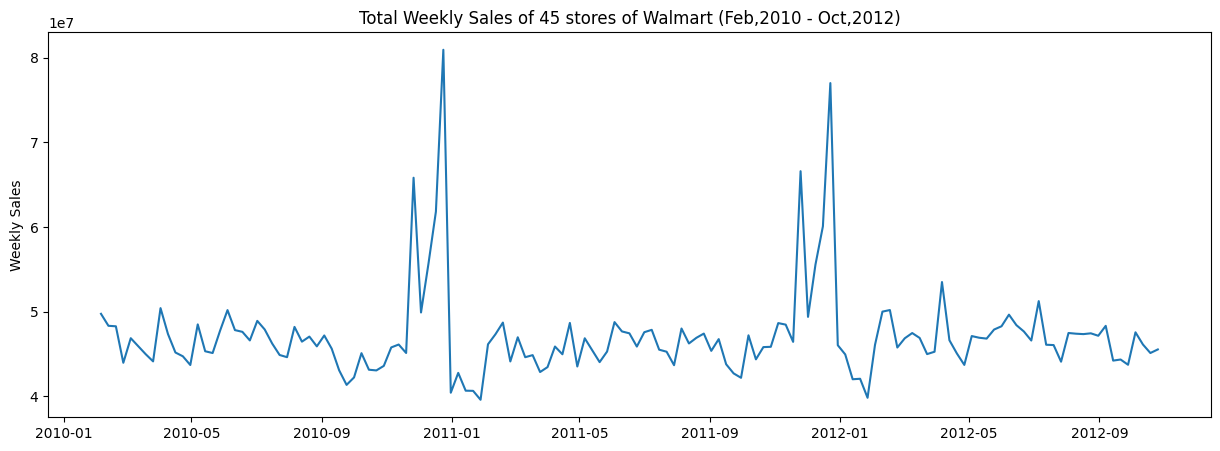

In [273]:
# Create a line plot with the sales information to review pattern of weekly sales
plt.figure(figsize=(15,5))
plt.plot(walmart_grouped_df['Date'], walmart_grouped_df['Weekly_Sales'])
plt.ylabel('Weekly Sales')
plt.title('Total Weekly Sales of 45 stores of Walmart (Feb,2010 - Oct,2012)')
plt.show()

In [274]:
# Get the weekly average (Week# and Weekly Sales) to use for prediction
weekly_sales_df = walmart_grouped_df.groupby(['week_of_year'])['Weekly_Sales'].sum().reset_index()

In [275]:
# Save files before Preparation for prediction model (download to local drive if testing in Google Colab)
walmart_grouped_df.to_csv('walmart_df_cleaned_lstm.csv', index=False)
weekly_sales_df.to_csv('walmart_weekly_df_lstm.csv', index=False)

### Manual splitting of the dataset due to low volume. Trying to split to provide a full year (52 weeks) for training and use the rest for testing

In [276]:
walmart_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Weekly_Sales  143 non-null    float64       
 1   Date          143 non-null    datetime64[ns]
 2   year          143 non-null    int64         
 3   year_week     143 non-null    int64         
 4   week_of_year  143 non-null    UInt32        
 5   Temperature   143 non-null    float64       
 6   Fuel_Price    143 non-null    float64       
 7   MarkDown1     143 non-null    float64       
 8   MarkDown2     143 non-null    float64       
 9   MarkDown3     143 non-null    float64       
 10  MarkDown4     143 non-null    float64       
 11  MarkDown5     143 non-null    float64       
 12  CPI           143 non-null    float64       
 13  Unemployment  143 non-null    float64       
 14  Type          143 non-null    int64         
 15  Size          143 non-null    int64     

### Splitting manually to train using 2010/2011 and 2012 for testing

In [277]:
walmart_grouped_df = pd.read_csv('walmart_df_cleaned_lstm.csv')
walmart_grouped_df['Date'] = pd.to_datetime(walmart_grouped_df['Date'])

In [278]:
walmart_grouped_df.dtypes

Weekly_Sales           float64
Date            datetime64[ns]
year                     int64
year_week                int64
week_of_year             int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                     int64
Size                     int64
IS_SUPERBOWL             int64
IS_LABORDAY              int64
IS_TGIVING               int64
IS_XMAS                  int64
dtype: object

In [ ]:
# train_data = walmart_grouped_df[(walmart_grouped_df['year'] == 2010) | (walmart_grouped_df['year'] == 2011)]
# test_data = walmart_grouped_df[(walmart_grouped_df['year'] == 2012)] 

In [ ]:
# print("Train: ", train_data.shape)
# print("Test:", test_data.shape )

Train:  (100, 20)
Test: (43, 20)


### Interpreting Linear Regression thru Statsmodels summary using Ordinary Least Square (OLS) function 

In [ ]:
# Get unique count of values for each component - can eliminate features that do not vary 
# train_data.nunique()

Weekly_Sales    100
year_week       100
Temperature     100
Fuel_Price      100
CPI             100
Unemployment    100
IS_SUPERBOWL      2
IS_LABORDAY       2
IS_TGIVING        2
IS_XMAS           2
dtype: int64

##### Notice R-squared value by varying features. If say value is 0.338, model only fits 33.8% of the data. Close to 1 (100%) should be the target. Based on results, use those features for prediction model. (https://www.statsmodels.org/ for more details to interpret summary)

In [281]:
# This is a common analysis for in-depth analysis for each component of the dataset
# Note: We can just use unscaled data here. Removing Markdown, type and size from features as they are bring down R-squared
# Retaining events as we wanted to include them for the model and R-squared is good with these features
ols_X = walmart_grouped_df[['year_week', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IS_SUPERBOWL', 'IS_LABORDAY', 'IS_TGIVING', 'IS_XMAS']]
ols_y = walmart_grouped_df['Weekly_Sales']
sm.add_constant(ols_X)
ols_residuals = sm.OLS(ols_y, ols_X).fit()
print(ols_residuals.summary())

                                 OLS Regression Results                                
Dep. Variable:           Weekly_Sales   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1502.
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                   6.48e-130
Time:                        22:44:39   Log-Likelihood:                         -2399.8
No. Observations:                 143   AIC:                                      4818.
Df Residuals:                     134   BIC:                                      4844.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [282]:
# Root mean square value is also very important. Get the value (need to check in class about the importance of this value)
# (general rule of thumb is rmse should be between 0.2 and 0.5) Here we get very high rmse but a good R-squared and Adj-rsquared
ols_pred = ols_residuals.predict(ols_X)
ols_rmse = rmse(ols_y, ols_pred)
print(ols_rmse)

4697900.649627907


### Preprocessing for LSTM Recurrent Neural Network Model (Long Short-Term Memory)

Note: Scale and then split

In [283]:
# Drop columns from train and test data to match features identified in statsmodel
new_df = walmart_grouped_df.drop(columns=['Date', 'year', 'week_of_year', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type', 'Size'])
model_cols = new_df.columns.to_list()
model_cols

['Weekly_Sales',
 'year_week',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'IS_SUPERBOWL',
 'IS_LABORDAY',
 'IS_TGIVING',
 'IS_XMAS']

In [284]:
# Normalize data - using MinMax Scaler or StandardScaler
# scaler = MinMaxScaler(feature_range=(-1,1))
# scaler = MinMaxScaler();
scaler = StandardScaler()
new_df_scaled = scaler.fit_transform(new_df.to_numpy())     # need to pass array to scale
new_df_scaled = pd.DataFrame(new_df_scaled, columns=model_cols)

In [285]:
# Create function to convert a df passed as input parameter into required output arrays (as desired by model) - we are using timestep=1
# y = first column and rest are X
# Time series prediction needs previous input to be fed as feature set of next
# Eg. df has WkSales, YearWk, Temp, FuelPr  and say we have 100 rows
# If we plan to feed 1 row of past input to next step (called Timestep and value 1 to be specified in model) then
# We create new df with 100 - 1 rows as row 1 will not have previous input and should not be fed in
# Row1 of X will have (WkSales, YearWk, Temp, FuelPr) from previous Row1 - 1 (first row of df) & y = current row value 
# Row2 will have Row2 - 1 values and y = row2 value

# This needs to be fed in matrix form like
# [[WkSales1, YearWk1, temp1, fuelpr1]] [wkSales2]
# [[WkSales2, YearWk2, temp2, fuelpr2]] [wkSales3]
# [[WkSales3, YearWk3, temp3, fuelpr3]] [wkSales4]

# If we plan to pass say a week's worth of past data as input feature, then specify timestep as 7 and have 7 sets of previous input arrays
# [[[Wk1 set], [Wk2 set], [Wk3 set], [Wk4], [Wk5], [Wk6], [Wk7]]] [Sales8]

# Here passing just the previous week (timestep = 1), so when we create the series with this requirement, we will end up with (total_rows -1) 
ts = new_df_scaled.to_numpy()
X = []
y = []

timesteps = 4

for i in range(len(new_df_scaled) - timesteps):
  row = [r for r in ts[i:i+timesteps]]         # returns the entire row of df in array format
  X.append(row)
  y_value = ts[i+timesteps][0]                   # just get the first element as that is Weekly_Sales
  y.append(y_value)

X1 = np.array(X)
y1 = np.array(y)

In [286]:
# Verify data shapes
X1.shape, y1.shape

((139, 4, 10), (139,))

In [287]:
# Splitting manually to try with different combinations
# 142 rows; the last 43 belong to year 2012 which will be split into validation (13 rows) and 30 rows for test; top 99 rows will be used for training
recs = 90
X_train, y_train = X1[:recs], y1[:recs]
# X_val, y_val = X1[99:111], y1[99:111]
X_test, y_test = X1[recs:], y1[recs:]

In [288]:
# Print shapes to verify
print("X_Train shape: ", X_train.shape)
print("y_Train shape: ", y_train.shape)
print("X_Test shape: ", X_test.shape)
print("y_Test shape: ", y_test.shape)

X_Train shape:  (90, 4, 10)
y_Train shape:  (90,)
X_Test shape:  (49, 4, 10)
y_Test shape:  (49,)


### Build Model, Compile and Train

In [ ]:
# Notes: stateful=True will use the last state of each sample as initial state of the next batch
# batch size must be specified for the layers if stateful is True (here values 1, 100 and 9 are being specified)
# Default activation of tanh is used unless 'None' is specified or any other value specified
# Units specifies the count of hidden layers - value of 4 specified here 
# input shape is 3-dimensional [sample count, timesteps, features]
# specifying Shuffle as false as we do not want dataset to be shuffled or randomized) - timeseries data and stateful=True to maintain the sequence
# lstm_model = Sequential()
# lstm_model.add(LSTM(units=4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))

# lstm_model.add(Dense(1))
# lstm_model.add(Dense(1))

# lstm_model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])

# lstm_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, shuffle=False)

In [289]:
# Try different configuration of model (Note: timesteps defined above in cell where df is converted to X/y arrays)
feature_count = X1.shape[2]
m2 = Sequential()
m2.add(InputLayer((timesteps, feature_count)))
m2.add(LSTM(64))
m2.add(Dense(8, 'relu'))
m2.add(Dense(1, 'linear'))
m2.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 64)                19200     
                                                                 
 dense_60 (Dense)            (None, 8)                 520       
                                                                 
 dense_61 (Dense)            (None, 1)                 9         
                                                                 
Total params: 19,729
Trainable params: 19,729
Non-trainable params: 0
_________________________________________________________________


In [290]:
m2.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

In [299]:
m2.fit(X_train, y_train, epochs=20)

Epoch 1/20
3/3 [==============================] - 0s 8ms/step - loss: 0.6001 - root_mean_squared_error: 0.7746
Epoch 2/20
3/3 [==============================] - 0s 7ms/step - loss: 0.5734 - root_mean_squared_error: 0.7572
Epoch 3/20
3/3 [==============================] - 0s 7ms/step - loss: 0.5446 - root_mean_squared_error: 0.7380
Epoch 4/20
3/3 [==============================] - 0s 6ms/step - loss: 0.5348 - root_mean_squared_error: 0.7313
Epoch 5/20
3/3 [==============================] - 0s 6ms/step - loss: 0.5031 - root_mean_squared_error: 0.7093
Epoch 6/20
3/3 [==============================] - 0s 6ms/step - loss: 0.4759 - root_mean_squared_error: 0.6899
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4450 - root_mean_squared_error: 0.6671
Epoch 8/20
3/3 [==============================] - 0s 7ms/step - loss: 0.4241 - root_mean_squared_error: 0.6512
Epoch 9/20
3/3 [==============================] - 0s 6ms/step - loss: 0.4093 - root_mean_squared_error: 0.6398
E

In [300]:
# Review statistics
m2_results = m2.evaluate(X_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.4620 - root_mean_squared_error: 0.6797


In [301]:
m2_res_dict = dict(zip(m2.metrics_names, m2_results))
print(m2_res_dict)

{'loss': 0.462035596370697, 'root_mean_squared_error': 0.6797320246696472}


#### Predict Model using Test Data

In [302]:
test_pred = m2.predict(X_test)

2/2 [==============================] - 0s 9ms/step


In [303]:
# Reshape tensor (matrix type) back to array
test_pred = np.array(test_pred)
result_array = test_pred.reshape(-1)
# print(result_array)

#### Create DataFrame from results and plot Actual Vs Predicted

In [304]:
test_results = pd.DataFrame(data={'Test_Pred': result_array, 'Actual': y_test})

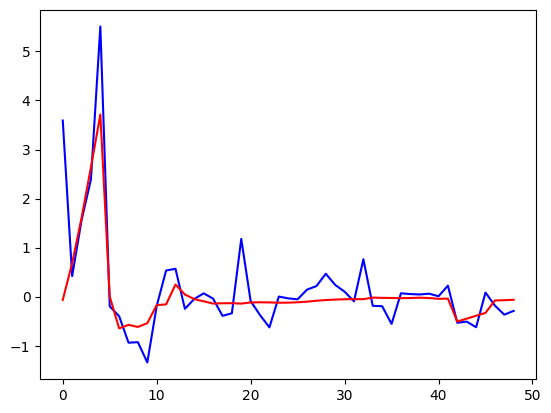

In [305]:
plt.plot(test_results['Actual'], c='blue')
plt.plot(test_results['Test_Pred'], c='red')

### Optional steps to unscale and use predicted data and calculate Predicted Sales. Then plot Actual Vs Predicted